# Sentiment Analysis and Natural Language processing

Before we begin, important things to keep in mind:

1. The enviroment you create at the begining, you only have to create it once. Afterwards, you can access the same enviroment with `conda activate name_of_environment`. If you do not remember the name of the environment you created, you can type `conda env list` to see all the existing environments you currently have in your system. 

2. If you are going to follow the instructions of this notebook exactly, just make sure that the folder structure you have looks the same as:
    - data : This is going to be the folder where you save all the data you are going to use for the analysis and processing. 
    - outputs : Here is where all the outputs are going to go (For example, the post processing dataset, the data visualization, etc.)
    - sentiment_analysis.ipynb : This is the main notebook. 

3. Please read the comments on the code as some of the cells only need to be run once (the first time you run the notebook) and after that, you only need to run them again if you change to another conda environment.


First we explain the different libraries we are going to be mainly using. First, we create an enviroment specialized for sentiment analysis

- `conda create -n sentiment python=3.9 -y`
- `conda activate sentiment`

Once you have the environment and have activated it, we can asign the kernel to this notebook. This kernel should be in the right-upper corner of your screen. 

## Installing the libraries

This instalation should only be done once, and please make sure that you are inside the conda environment before installing anything.

- pip install pandas
- pip install matplotlib
- pip install seaborn
- pip install scikit-learn
- pip install nltk
- pip install scipy
- pip install textblob
- pip install vaderSentiment
- pip install datasets


In [49]:
# Data handling

import pandas as pd
import numpy as np
import os, sys, string, re, csv

In [50]:
# Data visualization

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import seaborn as sns

In [51]:
# Data processing and manipulation

import sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from scipy.spatial.distance import cosine

import nltk


## IMPORTANT:

This next cell imports the corpus of the nltk library, so they should only be run once in the code. If you restart the kernel, they might need to be run again. 

In [52]:
# This part only has to be run once.

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annafreer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/annafreer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/annafreer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/annafreer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/annafreer/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [53]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Step 1: Data input

In this first step, we need to have our variables set up with the data that we are going to pre process and analyse.


In [55]:

from datasets import load_dataset
# Loading the data
dataset = load_dataset("text", data_files={"train": "annajournal - Sheet1.csv"})


Generating train split: 87 examples [00:00, 2829.33 examples/s]


When we print the dataset, we can see that it is not a regular format, but a dictionary. In this case we need to update it to be able to visualize it with pandas. 

In [56]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 87
    })
})


Datasets from hugging face have a module called `set_format` where you can choose how to manipulate your data. The most common one is pandas, so that way you can translate to other modes like csv, txt, json, etc.

In [57]:
dataset.set_format(type='pandas')

df = dataset['train'][:]
print(df.columns)
df.head(3)

Index(['text'], dtype='object')


,text
0,"Data,Entry"
1,"12 September,""Fresh book, fresh start. With th..."
2,"13 September,""I had a really good day yesterda..."


Now that we have it as a pandas data frame, you can use the same features discussed in the data processing module we saw in previous workshops. In this case, `value_counts()` helps you find out the unique values of the column you indicate, while also giving you the amount of times this value is repeated.

For this case we use the prompt type to separate. As we can see, we have a pretty evenly distributed set of prompts

In [58]:
#values, counts = np.unique(words, return_counts=True)

prompts = df['text'].value_counts()
prompts

text
Data,Entry                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [59]:
# #X_train.groupby('reqrealip_by_pkgname_count')['label'].value_counts()
# plt.rcParams["figure.figsize"] = [7, 7]
# plt.rcParams["figure.autolayout"] = True
# df.groupby('text')['rating_initial'].value_counts().unstack().plot.bar(stacked=True)
# plt.legend(bbox_to_anchor=(1.0, 1.0))
# plt.show()


In [60]:
df.columns

Index(['text'], dtype='object')

In [61]:
# sentiment = df.drop(['worker_id', 'source', 'prompt_type', 'rating_initial', 'rating_final', 'persuasiveness_metric'], axis = 1)
sentiment = df
sentiment.head(3)

,text
0,"Data,Entry"
1,"12 September,""Fresh book, fresh start. With th..."
2,"13 September,""I had a really good day yesterda..."


In [62]:
sentiment.shape

(87, 1)

In [63]:
import re

# Define a function to clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
sentiment['Cleaned_claims'] = sentiment['text'].apply(clean)
sentiment.head(3)

,text,Cleaned_claims
0,"Data,Entry",Data Entry
1,"12 September,""Fresh book, fresh start. With th...",September Fresh book fresh start With this I ...
2,"13 September,""I had a really good day yesterda...",September I had a really good day yesterday c...


In [64]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

sentiment['POS tagged'] = sentiment['Cleaned_claims'].apply(token_stop_pos)
sentiment.head()

,text,Cleaned_claims,POS tagged
0,"Data,Entry",Data Entry,"[(Data, n), (Entry, n)]"
1,"12 September,""Fresh book, fresh start. With th...",September Fresh book fresh start With this I ...,"[(September, n), (Fresh, n), (book, n), (fresh..."
2,"13 September,""I had a really good day yesterda...",September I had a really good day yesterday c...,"[(September, n), (really, r), (good, a), (day,..."
3,"14 September,""Today has not been so good but n...",September Today has not been so good but not ...,"[(September, n), (Today, n), (good, a), (total..."
4,"16 September,""Dear Anna, I want you to know ho...",September Dear Anna I want you to know how mu...,"[(September, n), (Dear, n), (Anna, n), (want, ..."


In [65]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_tagged):
    lemma_new = " "
    for word, pos in pos_tagged:
        if not pos:
            lemma = word
            lemma_new = lemma_new + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos = pos)
            lemma_new = lemma_new + " " + lemma
    return lemma_new

sentiment["Lemma"] = sentiment['POS tagged'].apply(lemmatize)
sentiment.head(3)

,text,Cleaned_claims,POS tagged,Lemma
0,"Data,Entry",Data Entry,"[(Data, n), (Entry, n)]",Data Entry
1,"12 September,""Fresh book, fresh start. With th...",September Fresh book fresh start With this I ...,"[(September, n), (Fresh, n), (book, n), (fresh...",September Fresh book fresh start go try stay...
2,"13 September,""I had a really good day yesterda...",September I had a really good day yesterday c...,"[(September, n), (really, r), (good, a), (day,...",September really good day yesterday chat mum...


## Using Textblob for sentiment analysis



In [66]:
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [67]:
sentiment

,text,Cleaned_claims,POS tagged,Lemma
0,"Data,Entry",Data Entry,"[(Data, n), (Entry, n)]",Data Entry
1,"12 September,""Fresh book, fresh start. With th...",September Fresh book fresh start With this I ...,"[(September, n), (Fresh, n), (book, n), (fresh...",September Fresh book fresh start go try stay...
2,"13 September,""I had a really good day yesterda...",September I had a really good day yesterday c...,"[(September, n), (really, r), (good, a), (day,...",September really good day yesterday chat mum...
3,"14 September,""Today has not been so good but n...",September Today has not been so good but not ...,"[(September, n), (Today, n), (good, a), (total...",September Today good totally lose go May Hil...
4,"16 September,""Dear Anna, I want you to know ho...",September Dear Anna I want you to know how mu...,"[(September, n), (Dear, n), (Anna, n), (want, ...",September Dear Anna want know much love love...
...,...,...,...,...
82,"19 January,""Dear Anna, Yesterday what is the h...",January Dear Anna Yesterday what is the hotte...,"[(January, n), (Dear, n), (Anna, n), (Yesterda...",January Dear Anna Yesterday hot day awhile f...
83,"21 January,""Dear Anna, I was sick yesterday wh...",January Dear Anna I was sick yesterday when I...,"[(January, n), (Dear, n), (Anna, n), (sick, v)...",January Dear Anna sick yesterday mean work l...
84,"23 January,""Dear Anna, I got wasted last night...",January Dear Anna I got wasted last night wit...,"[(January, n), (Dear, n), (Anna, n), (got, v),...",January Dear Anna get waste last night winte...
85,"27 January,""Dear Anna, I feel a lot better now...",January Dear Anna I feel a lot better now com...,"[(January, n), (Dear, n), (Anna, n), (feel, v)...",January Dear Anna feel lot well come need re...


In [68]:
lemma_data = pd.DataFrame(sentiment[['text', 'Lemma']])
lemma_data['Polarity'] = lemma_data['Lemma'].apply(getPolarity)
lemma_data['Analysis'] = lemma_data['Polarity'].apply(analysis)
lemma_data.head(10)

,text,Lemma,Polarity,Analysis
0,"Data,Entry",Data Entry,0.000000,Neutral
1,"12 September,""Fresh book, fresh start. With th...",September Fresh book fresh start go try stay...,0.218045,Positive
2,"13 September,""I had a really good day yesterda...",September really good day yesterday chat mum...,0.187338,Positive
3,"14 September,""Today has not been so good but n...",September Today good totally lose go May Hil...,0.060000,Positive
4,"16 September,""Dear Anna, I want you to know ho...",September Dear Anna want know much love love...,0.471429,Positive
5,"18 September,""The last two days have been very...",September last two day intense Saturday cry ...,0.146250,Positive
6,"23 September,""Dear Anna, Today is Svenny’s 25t...",September Dear Anna Today Svenny th Birthday...,0.163125,Positive
7,"24 September,""Dear Anna, I’m loving the affirm...",September Dear Anna love affirmation app Jon...,0.111351,Positive
8,"25 September,""Dear Anna, Busy day, first day b...",September Dear Anna Busy day first day back ...,0.365909,Positive
9,"26 September,""Dear Anna Well done for organisi...",September Dear Anna Well do organise house g...,0.335000,Positive


In [69]:
tb_counts = lemma_data.Analysis.value_counts()
tb_counts

Analysis
Positive    82
Neutral      3
Negative     2
Name: count, dtype: int64

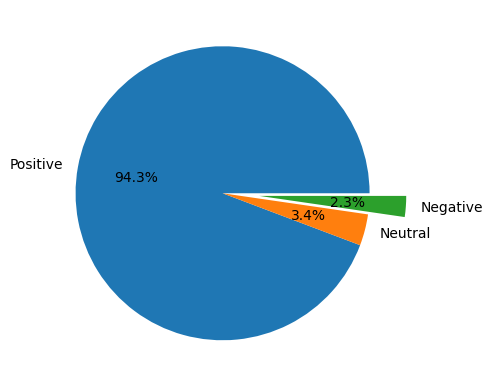

In [70]:
tb_count= lemma_data.Analysis.value_counts()
plt.figure(figsize=(5, 5))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.show()

In [71]:
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

lemma_data['Vader Sentiment'] = lemma_data['Lemma'].apply(vadersentimentanalysis)

In [72]:
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
    
    

In [73]:
lemma_data['Vader Analysis'] = lemma_data['Vader Sentiment'].apply(vader_analysis)
lemma_data.head()

,text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,"Data,Entry",Data Entry,0.000000,Neutral,0.0000,Neutral
1,"12 September,""Fresh book, fresh start. With th...",September Fresh book fresh start go try stay...,0.218045,Positive,0.9919,Positive
2,"13 September,""I had a really good day yesterda...",September really good day yesterday chat mum...,0.187338,Positive,0.6901,Positive
3,"14 September,""Today has not been so good but n...",September Today good totally lose go May Hil...,0.060000,Positive,0.1960,Neutral
4,"16 September,""Dear Anna, I want you to know ho...",September Dear Anna want know much love love...,0.471429,Positive,0.9870,Positive


In [74]:
vader_counts = lemma_data['Vader Analysis'].value_counts()
vader_counts

Vader Analysis
Positive    78
Neutral      9
Name: count, dtype: int64

ValueError: 'explode' must be of length 'x'

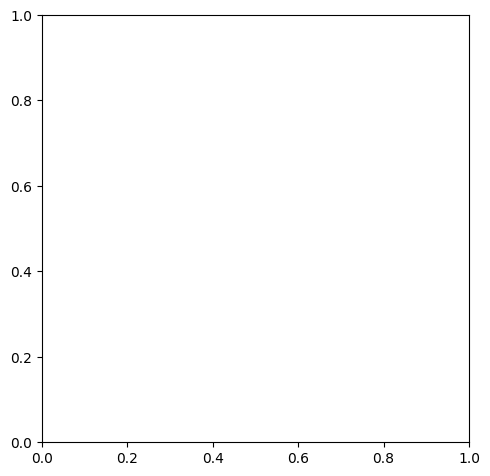

In [75]:
vader_counts= lemma_data['Vader Analysis'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
plt.show()

In [76]:
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"

lemma_data['SWN analysis'] = sentiment['POS tagged'].apply(sentiwordnetanalysis)
lemma_data.head()

,text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,"Data,Entry",Data Entry,0.000000,Neutral,0.0000,Neutral,Neutral
1,"12 September,""Fresh book, fresh start. With th...",September Fresh book fresh start go try stay...,0.218045,Positive,0.9919,Positive,Positive
2,"13 September,""I had a really good day yesterda...",September really good day yesterday chat mum...,0.187338,Positive,0.6901,Positive,Positive
3,"14 September,""Today has not been so good but n...",September Today good totally lose go May Hil...,0.060000,Positive,0.1960,Neutral,Positive
4,"16 September,""Dear Anna, I want you to know ho...",September Dear Anna want know much love love...,0.471429,Positive,0.9870,Positive,Positive


In [77]:
swn_counts= lemma_data['SWN analysis'].value_counts()
swn_counts


SWN analysis
Positive    82
Negative     4
Neutral      1
Name: count, dtype: int64

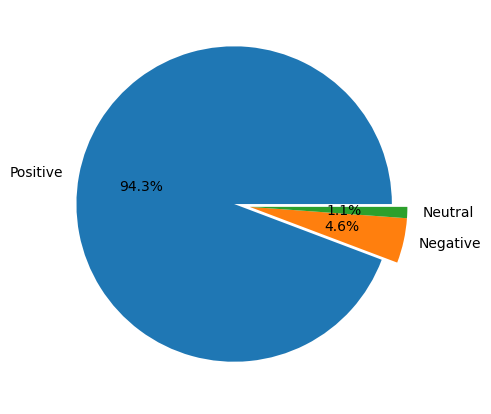

In [78]:
swn_counts= lemma_data['SWN analysis'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
plt.show()


## Using deep learning for sentiment analysis

For this next part you have to install **tensorflow** and **Keras** in order to work. Please make sure you follow the steps for this installation acording to your operating system.

Please ensure you have also installed transformers. 

- pip install transformers


In [79]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis', 
                    model='arpanghoshal/EmoRoBERTa')

emotion_labels = emotion(sentiment['Lemma'][0])
print(emotion_labels)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[{'label': 'neutral', 'score': 0.9967880249023438}]


In [80]:
print(sentiment['Lemma'][1])

  September Fresh book fresh start go try stay positive enjoy little thing thing everyday try ask currently home alone London good today think Em go go IKEA Yesterday Willf get accept flat Bristol say show good night George really good birthday watch cricket Everything look believe far come important look mental health also family friend speak Dad yesterday think friendship group struggle Im use always people round think fair think also need feel need like much purpose moment back uni two week start new job next week hopefully go enjoy time home get fresh air also gon na try keep soothe inner dialogue currently direct Lots love Anna


In [81]:
lemma_data['Berta'] = sentiment['Lemma'].apply(emotion)
lemma_data.head()

,text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis,Berta
0,"Data,Entry",Data Entry,0.000000,Neutral,0.0000,Neutral,Neutral,"[{'label': 'neutral', 'score': 0.9967880249023..."
1,"12 September,""Fresh book, fresh start. With th...",September Fresh book fresh start go try stay...,0.218045,Positive,0.9919,Positive,Positive,"[{'label': 'joy', 'score': 0.6414938569068909}]"
2,"13 September,""I had a really good day yesterda...",September really good day yesterday chat mum...,0.187338,Positive,0.6901,Positive,Positive,"[{'label': 'neutral', 'score': 0.9708040356636..."
3,"14 September,""Today has not been so good but n...",September Today good totally lose go May Hil...,0.060000,Positive,0.1960,Neutral,Positive,"[{'label': 'amusement', 'score': 0.44898363947..."
4,"16 September,""Dear Anna, I want you to know ho...",September Dear Anna want know much love love...,0.471429,Positive,0.9870,Positive,Positive,"[{'label': 'love', 'score': 0.9859309196472168}]"


In [82]:
# https://www.freecodecamp.org/news/dataframe-to-csv-how-to-save-pandas-dataframes-by-exporting/

lemma_data.to_csv('data/sentiment_analysis.csv', index=False)